In [66]:
import keras
from keras.datasets import mnist

import numpy as np

import matplotlib.pyplot as plt

REGULAR_EPOCHS = 2
REGULAR_BATCH_SIZE = 128

import sklearn.decomposition
import sklearn.neighbors
import sklearn.manifold

import random

import time

import pickle

import numba

<a id="segundo"></a>
## 2. Autoencoders (AEs) en MNIST


Como se ha discutido en clases, las RBM’s y posteriormente los AE’s (redes no supervisadas) fueron un componente crucial en el desarrollo de los modelos que entre 2006 y 2010 vigorizaron el área de las redes neuronales artificiales con logros notables de desempeño en diferentes tareas de aprendizaje automático. En esta sección aprenderemos a utilizar el más sencillo de estos modelos: un autoencoder o AE. Consideraremos tres aplicaciones clásicas: reducción de dimensionalidad, *denoising* y pre-entrenamiento. Con este objetivo en mente, utilizaremos un dataset denominado MNIST[[3]](#refs). Se trata de una colección de 70000 imágenes de 28 $\times$ 28 pixeles correspondientes a dígitos manuscritos (números entre 0 y 9). En su versión tradicional, la colección se encuentra separada en dos subconjuntos: uno de entrenamiento de 60000 imágenes y otro de test de 10000 imágenes. La tarea consiste en construir un programa para que aprenda a identificar correctamente el dı́gito representado en la imagen

---

a) Escriba el código que **cargue los datos** desde el repositorio de keras, normalice las imágenes de modo que los pixeles queden en [0, 1], transforme las imágenes en vectores ($\in {\rm I\!R}^{784}$) y devuelva tres subconjuntos disjuntos: uno de entrenamiento, uno de validación y uno de pruebas. Construya el conjunto de validación de la manera que estime conveniente, éste debe contar con $nval = 5000$ imágenes.

In [107]:
(x_training, y_training), (x_test, y_test) = mnist.load_data()
x_training = x_training.astype('float32')/255.
x_test  = x_test.astype('float32') /255.

# Shuffle train data:
n_vali = 5000
indexes = np.arange(x_training.shape[0])
np.random.shuffle(indexes)

x_val = x_training[indexes[:n_vali]]
y_val = y_training[indexes[:n_vali]]
x_tra = x_training[indexes[n_vali:]]
y_tra = y_training[indexes[n_vali:]]

print("x_val.shape",x_val.shape)
print("y_val.shape",y_val.shape)
print("x_tra.shape",x_tra.shape)
print("y_tra.shape",y_tra.shape)
print("x_test.shape",x_test.shape)
print("y_test.shape",y_test.shape)

x_val.shape (5000, 28, 28)
y_val.shape (5000,)
x_tra.shape (55000, 28, 28)
y_tra.shape (55000,)
x_test.shape (10000, 28, 28)
y_test.shape (10000,)


---

### 2.1 Reducción de dimensionalidad
Para esta primera sección, gracias a la simplicidad del problema tratado, se experimentará con un autoencoder tradicional (*feed forward*) en donde las capas de éste sean densas. Para esto se re estructurarán los datos de entradas en forma de vector, es decir la matriz de 28 $\times$ 28 pasa a ser un vector de 784 componentes.

In [108]:
x_tra_f = x_tra.reshape((len(x_tra),np.prod(x_tra.shape[1:])))
x_val_f = x_val.reshape((len(x_val),np.prod(x_val.shape[1:])))
x_test_f = x_test.reshape((len(x_test),np.prod(x_test.shape[1:])))

print("x_tra_f.shape",x_tra_f.shape)
print("x_val_f.shape",x_val_f.shape)
print("x_test_f.shape",x_test_f.shape)

x_tra_f.shape (55000, 784)
x_val_f.shape (5000, 784)
x_test_f.shape (10000, 784)


Una de las aplicaciones tı́picas de un AE es reducción de dimensionalidad, es decir, implementar una transformación $\phi:{\rm I\!R}^d \rightarrow {\rm I\!R}^{d'}$ de objetos representados originalmente por $d$ atributos en una nueva representación de $d'$ atributos, de modo tal que se preserve lo mejor posible la “información” original. Obtener tal representación es útil desde un punto de vista computacional (compresión) y estadı́stico (permite construir modelos con un menor número de parámetros libres). Un AE es una técnica de reducción de dimensionalidad no supervisada porque no hace uso de información acerca de las clases a las que pertenecen los datos de entrenamiento.  

---

a) Entrene un AE básico (1 capa escondida) para generar una representación de MNIST en $d'$= 2, 8, 32, 64 dimensiones. **Justifique la elección de la función de pérdida a utilizar y del criterio de entrenamiento en general**. Determine el porcentaje de compresión obtenido y el error de reconstrucción en cada caso. **¿Mejora el resultado si elegimos una función de activación *ReLU* para el *Encoder*? ¿Podrı́a y/o corresponde utilizar ésta activación en el *Decoder*?**

In [26]:
def autoencoder(dims,activ):
    # Layers
    input_img = keras.layers.Input(shape=(784,))
    encoded = keras.layers.Dense(dims, activation=activ)(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid')(encoded)
    # Whole Autoencoder
    autoencoder = keras.models.Model(inputs=input_img,outputs=decoded)
    # Encoder
    encoder = keras.models.Model(inputs=input_img,outputs=encoded)
    # Decoder
    encoded_input = keras.layers.Input(shape=(dims,))
    decoder_layer = autoencoder.layers[-1]
    decoder = keras.models.Model(inputs=encoded_input,outputs=decoder_layer(encoded_input))
    # Return the 3 models
    return autoencoder,encoder,decoder

In [5]:
DIMS = (2,8,32,64)

In [25]:
# ---@> Train models:
for dim in DIMS:
    for activ in ('sigmoid','relu'):
        model_ae,model_e,model_d = autoencoder(dim,activ)
        model_ae.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
        model_ae.fit(x_tra_f,x_tra_f,epochs=REGULAR_EPOCHS,batch_size=REGULAR_BATCH_SIZE,
                     validation_data=(x_val_f,x_val_f))
        model_e.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
        model_d.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
        model_e.save("basic_e_%d_%s.h5"%(dim,activ))
        model_d.save("basic_d_%d_%s.h5"%(dim,activ))
        model_ae.save("basic_ae_%d_%s.h5"%(dim,activ))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 2s 40us/step - loss: 0.2301 - val_loss: 0.2285
Epoch 2/2
55000/55000 [==============================] - 1s 23us/step - loss: 0.2267 - val_loss: 0.2249
Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 2s 40us/step - loss: 0.2300 - val_loss: 0.2286
Epoch 2/2
55000/55000 [==============================] - 1s 24us/step - loss: 0.2243 - val_loss: 0.2152
Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 2s 45us/step - loss: 0.2279 - val_loss: 0.2239
Epoch 2/2
55000/55000 [==============================] - 1s 27us/step - loss: 0.2191 - val_loss: 0.2137
Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 2s 42us/step - loss: 0.2287 - val_loss: 0.2241
Epoch 2/2
55000/55000 [==============================] - 1s 24us/step - loss

In [6]:
test_recerr = {}
# Get errors
for dim in DIMS:
    for activ in ('sigmoid','relu'):
        name = "basic_ae_%d_%s.h5"%(dim,activ)
        ae = keras.models.load_model(name)
        x_pred_tra_f = ae.predict(x_tra_f,batch_size=REGULAR_BATCH_SIZE)
        x_pred_test_f = ae.predict(x_test_f,batch_size=REGULAR_BATCH_SIZE)
        error_tra = np.mean((x_pred_tra_f-x_tra_f)**2)
        error_test = np.mean((x_pred_test_f-x_test_f)**2)
        print("%-30s  tr_err:%.7f  te_err:%.7f"%(name,error_tra,error_test))
        test_recerr[name] = error_test

basic_ae_2_sigmoid.h5           tr_err:0.2248682  te_err:0.2249686
basic_ae_2_relu.h5              tr_err:0.2152215  te_err:0.2151709
basic_ae_8_sigmoid.h5           tr_err:0.2137244  te_err:0.2137634
basic_ae_8_relu.h5              tr_err:0.1613936  te_err:0.1607234
basic_ae_32_sigmoid.h5          tr_err:0.1864602  te_err:0.1864205
basic_ae_32_relu.h5             tr_err:0.1292944  te_err:0.1284212
basic_ae_64_sigmoid.h5          tr_err:0.1619870  te_err:0.1619253
basic_ae_64_relu.h5             tr_err:0.1070074  te_err:0.1061174


---

b) Compare visualmente la reconstrucción que logra hacer el *autoencoder* desde la representación en ${\rm I\!R}^{d'}$ para algunas imágenes del conjunto de pruebas. **Determine si la percepción visual se corresponde con el error de reconstrucción observada**. Comente.

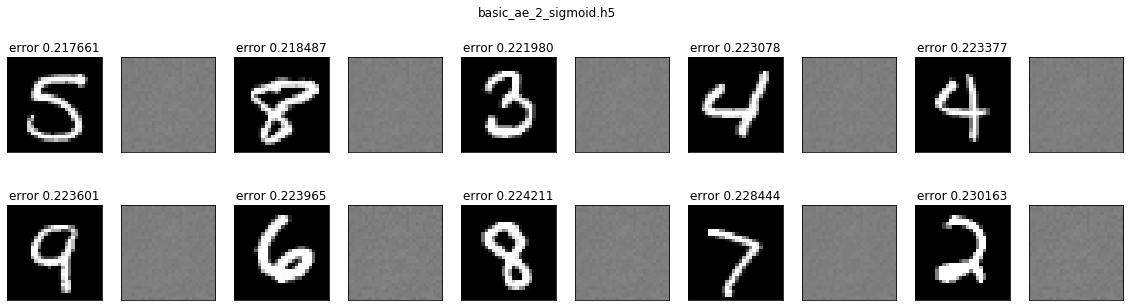

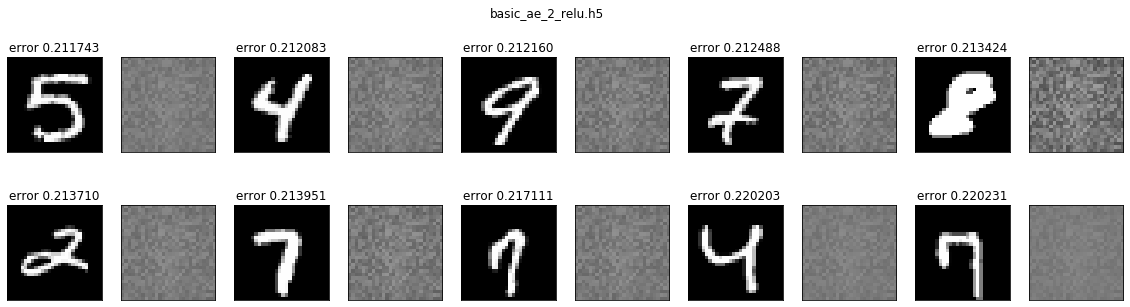

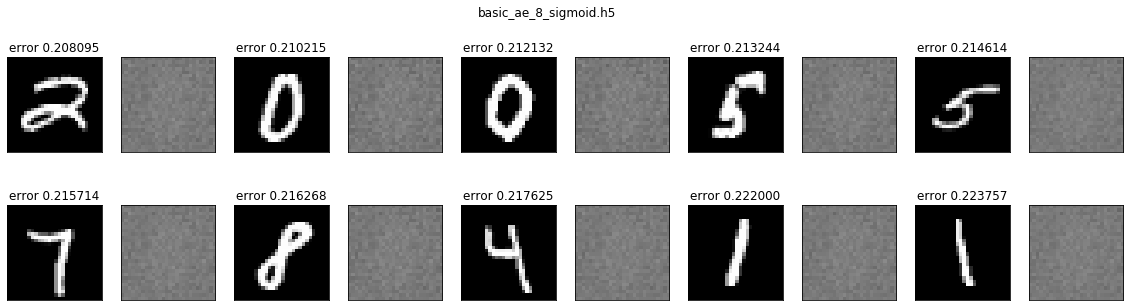

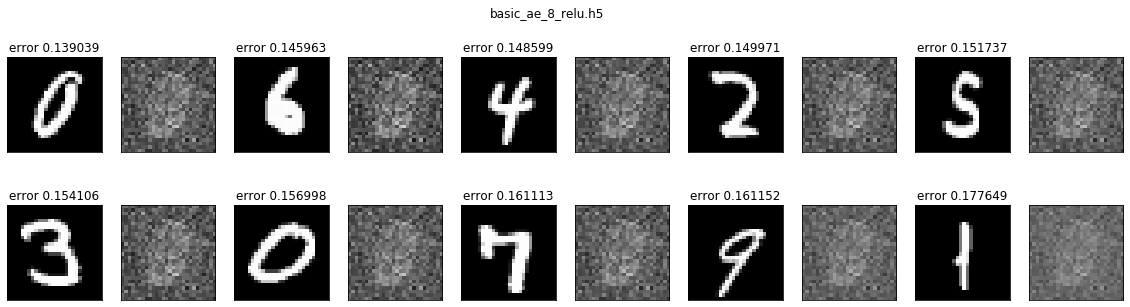

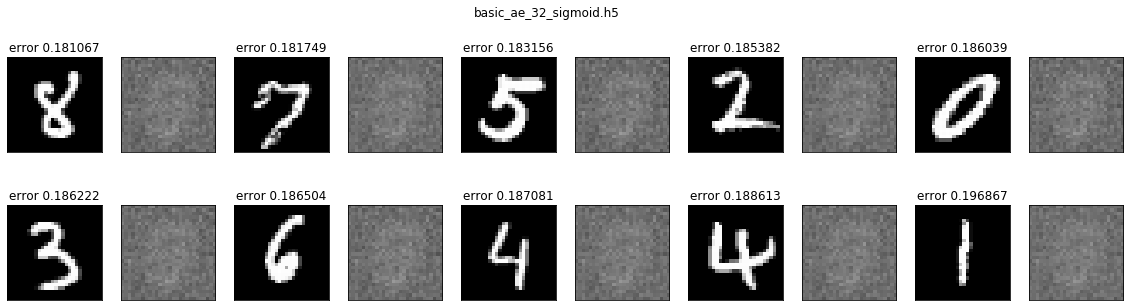

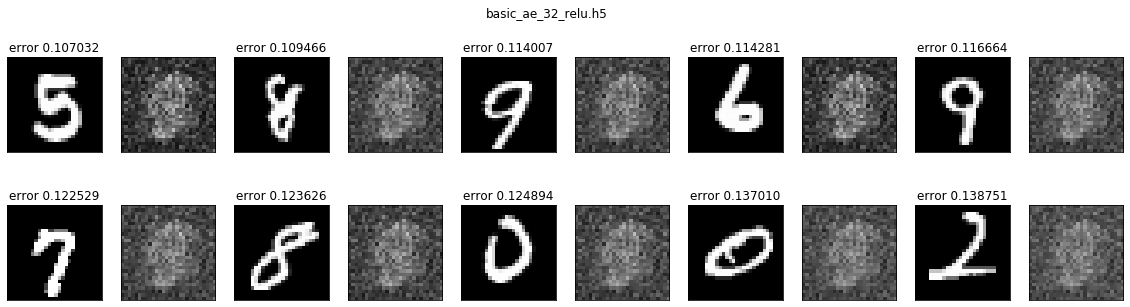

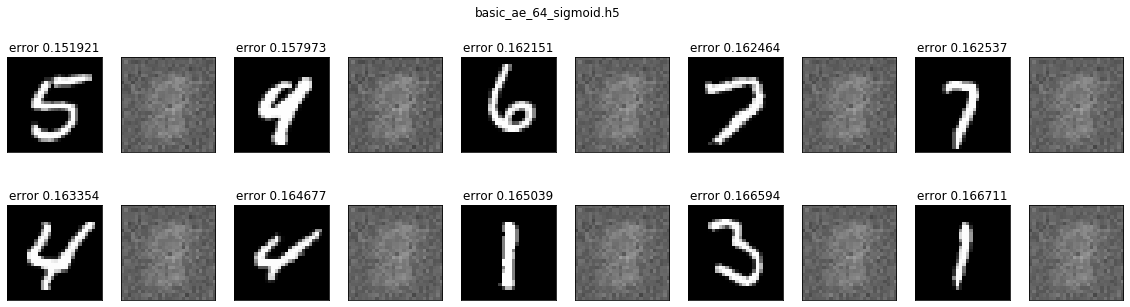

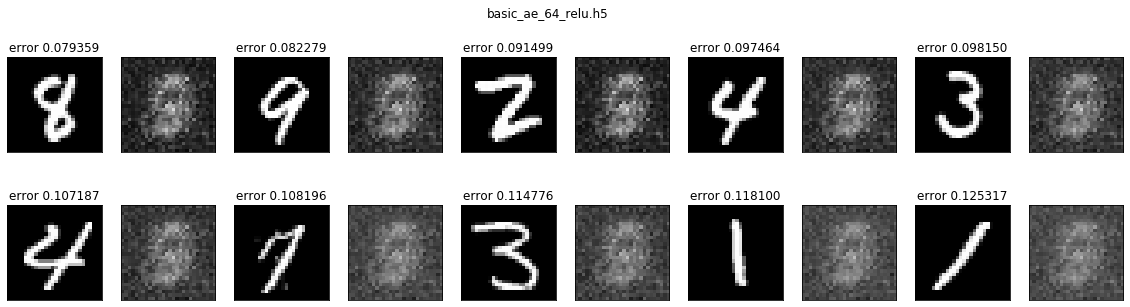

In [109]:
# Get errors
for dim in DIMS:
    for activ in ('sigmoid','relu'):
        name = "basic_ae_%d_%s.h5"%(dim,activ)
        ae = keras.models.load_model(name)
        idxs = np.arange(x_test_f.shape[0])
        np.random.shuffle(idxs)
        N = 10
        idxs = idxs[:N]
        reals = x_test_f[idxs]
        preds = ae.predict(reals)
        errors = np.mean((reals-preds)**2,axis=1)
        # Sort in increasing error
        trf = np.argsort(errors)
        reals = reals[trf]
        preds = preds[trf]
        errors = errors[trf]
        #
        plt.figure(figsize=(2*N,5))
        plt.suptitle(name)
        for i in range(N):
            ax = plt.subplot(2,N,2*i+1)
            ax.set_title("error %f"%errors[i])
            ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
            plt.imshow(reals[i].reshape(28,28),cmap='gray',vmin=0,vmax=1)
            ax = plt.subplot(2,N,2*i+2)
            ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
            plt.imshow(preds[i].reshape(28,28),cmap='gray',vmin=0,vmax=1)
        plt.show()


---

c) Para verificar la calidad de la representación obtenida, implemente el clasificador denominado $kNN$ (k-nearest neighbor): dada una imagen $x$, el clasificador busca las k = 10 imágenes de entrenamiento más similares (de acuerdo a una distancia, e.g. euclidiana) y predice como clase, la etiqueta más popular entre las imágenes cercanas. **Mida el error de pruebas** obtenido construyendo este clasificador sobre la data reducida a través del *autoencoder* comparando con la representación reducida obtenida vía PCA (una técnica clásica de reducción de dimensionalidad) utilizando el mismo número de dimensiones $d'$= 2, 4, 8, 16, 32. Considere tanto el error de reconstrucción como el desempeño en clasificación , además de comparar los tiempos medios de predicción en ambos escenarios **¿La representación generada por el *autoencoder* logra generalizar?**

In [8]:
# Get errors
for dim in DIMS:
    # PCA
    pca = sklearn.decomposition.PCA(n_components=dim)
    pca.fit(x_tra_f)
    pca_train = pca.transform(x_tra_f)
    #
    clf = sklearn.neighbors.KNeighborsClassifier(10)
    clf.fit(pca_train,y_tra)
    #
    start = time.time()
    pca_test = pca.transform(x_test_f)
    score = clf.score(pca_test,y_test)
    elapsed = time.time()-start
    #
    print('%3ddims %-15s  score:%.3f   time:%8.3f[s]'%(
        dim,'pca',score,elapsed))
    #
    for activ in ('sigmoid','relu'):
        # AUTOENCODER
        nameae = "basic_ae_%d_%s.h5"%(dim,activ)
        name = "basic_e_%d_%s.h5"%(dim,activ)
        enc = keras.models.load_model(name)
        enc_train = enc.predict(x_tra_f)
        clf = sklearn.neighbors.KNeighborsClassifier(10)
        clf.fit(enc_train,y_tra)
        #
        start = time.time()
        enc_test = enc.predict(x_test_f)
        score = clf.score(enc_test,y_test)
        elapsed = time.time()-start
        #
        print('%3ddims %-15s  score:%.3f   time:%8.3f[s]  recons:%.3f'%(
        dim,'ae_'+activ,score,elapsed,test_recerr[nameae]))

  2dims pca              score:0.440   time:   0.062[s]
  2dims ae_sigmoid       score:0.241   time:   0.198[s]  recons:0.225
  2dims ae_relu          score:0.161   time:   0.271[s]  recons:0.215
  8dims pca              score:0.904   time:   1.003[s]
  8dims ae_sigmoid       score:0.585   time:   1.626[s]  recons:0.214
  8dims ae_relu          score:0.535   time:   1.145[s]  recons:0.161
 32dims pca              score:0.974   time:  23.402[s]
 32dims ae_sigmoid       score:0.905   time:  48.741[s]  recons:0.186
 32dims ae_relu          score:0.841   time:  18.066[s]  recons:0.128
 64dims pca              score:0.972   time:  51.818[s]
 64dims ae_sigmoid       score:0.938   time: 109.623[s]  recons:0.162
 64dims ae_relu          score:0.900   time:  38.104[s]  recons:0.106


---

d) Modifique el *autoencoder* básico construido en (a) para implementar un deep autoencoder (*deep AE*), es decir, un autoencoder con al menos dos capas ocultas. **Demuestre experimentalmente** que este *autoencoder* puede mejorar la compresión obtenida por PCA utilizando el mismo número de dimensiones $d'$ . Experimente con $d'$ =2, 4, 8, 16 y distintas profundidades ($L \in [2,4]$). Considere en esta comparación tanto el error de reconstrucción como el desempeño en clasificación (vı́a kNN) de cada representación. Comente.

In [9]:
def deep_autoencoder(dims,nneurons=(1000,500,250)):
    # Layers
    input_img = keras.layers.Input(shape=(784,))
    enc_layers = [keras.layers.Dense(x,activation='relu') for x in nneurons]
    enc_layers.append(keras.layers.Dense(dims,activation='relu'))
    dec_layers = [keras.layers.Dense(x,activation='relu') for x in nneurons[::-1]]
    dec_layers.append(keras.layers.Dense(784,activation='sigmoid'))
    # Encoding
    front = input_img
    for la in enc_layers:
        front = la(front)
    encoder = front
    # Decoding
    for la in dec_layers:
        front = la(front)
    # Whole Autoencoder
    autoenc = keras.models.Model(inputs=input_img,outputs=front)
    # Encoder
    encoder = keras.models.Model(inputs=input_img,outputs=encoder)
    # Decoder
    encoded_input = keras.layers.Input(shape=(dims,))
    front = encoded_input
    for la in dec_layers:
        front = la(front)
    decoder = keras.models.Model(inputs=encoded_input,outputs=front)
    # Return the 3 models
    return autoenc,encoder,decoder

In [10]:
ARCHS = {'2la':[500,250],'4la':[1000,750,500,250]}
DIMS2 = [2,4,8,16]

In [37]:
# ---@> Train models:
for dim in DIMS2:
    for idc in ARCHS:
        neurons= ARCHS[idc]
        name = "deep_%s_ae_%d.h5"%(idc,dim)
        ename = "deep_%s_e_%d.h5"%(idc,dim)
        dname = "deep_%s_d_%d.h5"%(idc,dim)
        model_ae,model_e,model_d = deep_autoencoder(dim,neurons)
        model_ae.compile(optimizer=keras.optimizers.SGD(lr=1.0),loss='mse')
        model_ae.fit(x_tra_f,x_tra_f,epochs=REGULAR_EPOCHS,batch_size=REGULAR_BATCH_SIZE)
        model_ae.save(name)
        #
        model_e.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
        model_d.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
        model_e.save(ename)
        model_d.save(dname)

Epoch 1/2
55000/55000 [==============================] - 9s 172us/step - loss: 0.0985
Epoch 2/2
55000/55000 [==============================] - 9s 162us/step - loss: 0.0667
Epoch 1/2
55000/55000 [==============================] - 32s 581us/step - loss: 0.1022
Epoch 2/2
55000/55000 [==============================] - 31s 558us/step - loss: 0.0650
Epoch 1/2
55000/55000 [==============================] - 9s 165us/step - loss: 0.1155
Epoch 2/2
55000/55000 [==============================] - 8s 152us/step - loss: 0.0670
Epoch 1/2
55000/55000 [==============================] - 32s 581us/step - loss: 0.1019
Epoch 2/2
55000/55000 [==============================] - 33s 595us/step - loss: 0.0649
Epoch 1/2
55000/55000 [==============================] - 10s 182us/step - loss: 0.0897
Epoch 2/2
55000/55000 [==============================] - 9s 160us/step - loss: 0.0667
Epoch 1/2
55000/55000 [==============================] - 31s 572us/step - loss: 0.1007
Epoch 2/2
55000/55000 [=========================

In [11]:
for dim in DIMS2:
    # PCA
    pca = sklearn.decomposition.PCA(n_components=dim)
    pca.fit(x_tra_f)
    pca_tra = pca.transform(x_tra_f)
    pca_test = pca.transform(x_test_f)
    clf = sklearn.neighbors.KNeighborsClassifier(10)
    clf.fit(pca_tra,y_tra)
    score = clf.score(pca_test,y_test)
    #
    print("%2ddims %-30s  score:%.3f"%(dim,'pca',score))
    #
    for idc in sorted(list(ARCHS)):
        name = "deep_%s_ae_%d.h5"%(idc,dim)
        ename = "deep_%s_e_%d.h5"%(idc,dim)
        autoenc = keras.models.load_model(name)
        encoder = keras.models.load_model(ename)
        # Reconstruction error
        x_test_pred_f = autoenc.predict(x_test_f,batch_size=REGULAR_BATCH_SIZE)
        recon_error = np.mean(np.mean((x_test_pred_f-x_test_f)**2,axis=1))
        # Clasification error:
        x_tra_enc = encoder.predict(x_tra_f,batch_size=REGULAR_BATCH_SIZE)
        x_test_enc = encoder.predict(x_test_f,batch_size=REGULAR_BATCH_SIZE)
        clf = sklearn.neighbors.KNeighborsClassifier(10)
        clf.fit(x_tra_enc,y_tra)
        score = clf.score(x_test_enc,y_test)
        print("%2ddims %-30s  score:%.3f  recons:%.3f"%(dim,name,score,recon_error))

 2dims pca                             score:0.440
 2dims deep_2la_ae_2.h5                score:0.319  recons:0.066
 2dims deep_4la_ae_2.h5                score:0.260  recons:0.064
 4dims pca                             score:0.651
 4dims deep_2la_ae_4.h5                score:0.305  recons:0.066
 4dims deep_4la_ae_4.h5                score:0.307  recons:0.065
 8dims pca                             score:0.904
 8dims deep_2la_ae_8.h5                score:0.564  recons:0.066
 8dims deep_4la_ae_8.h5                score:0.276  recons:0.064
16dims pca                             score:0.960
16dims deep_2la_ae_16.h5               score:0.715  recons:0.062
16dims deep_4la_ae_16.h5               score:0.608  recons:0.065


---

e) Elija algunas de las representaciones aprendidas anteriormente ($d>2$) y visualı́celas usando la herramienta *TSNE* disponible en la librerı́a *sklearn*. **Compare cualitativamente el resultado con aquel obtenido usando PCA** con el mismo número de componentes ($d>2$). Finalmente **grafique una representación** generada por un autoencoder directamente ($d=2$), comente.

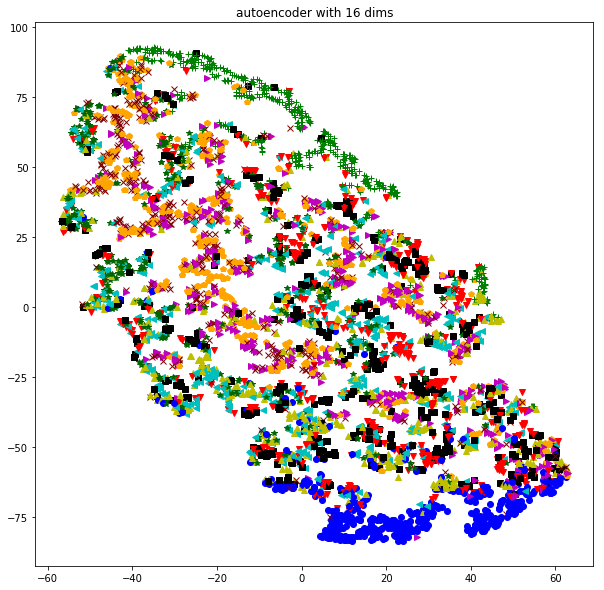

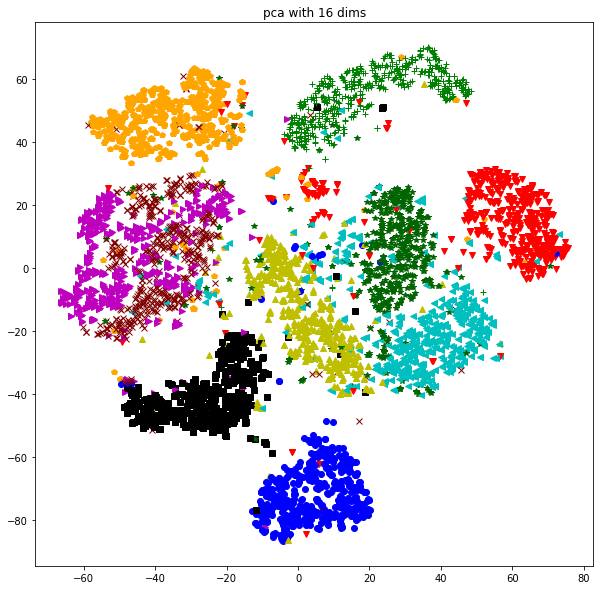

In [12]:
dims = 16
encoder = keras.models.load_model("deep_2la_e_%d.h5"%dims)

nplot = 2000
for t in (0,1):
    if t==0:
        enc_tra = encoder.predict(x_tra_f[:nplot])
    else:
        pca = sklearn.decomposition.PCA(n_components=dim)
        pca.fit(x_tra_f)
        pca_train = pca.transform(x_tra_f)
        enc_tra = pca_train[:nplot]
    #
    model = sklearn.manifold.TSNE(n_components=2,random_state=0)
    enc_tra = model.fit_transform(enc_tra)

    # Plot with tnse:
    plt.figure(figsize=(10,10))
    plt.title(("autoencoder" if t==0 else "pca")+" with %d dims"%dims)
    colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
    markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
    for idx in range(nplot):
        label = y_tra[idx]
        line = plt.plot(enc_tra[idx][0],enc_tra[idx][1],
            color=colors[label], marker=markers[label], markersize=6)
    plt.show()

---

f) Cuando el problema se torna más difícil es necesario complejizar el modelo. Modifique el autoencoder construido en (a) para trabajar directamente sobre las imágenes de MNIST, sin tratarlas como vectores de 784 atributos, sino como matrices de tamaño $1\times28\times28$. Es posible lograr este objetivo utilizando capas convolucionales para definir el *Encoder* y capas con **convoluciones transpuesta** en el *Decoder*, comente como sufre las transformaciones el patrón de entrada. Compare la calidad de la representación reducida obtenida por el nuevo autoencoder con aquella obtenida anteriormente utilizando el mismo número de dimensiones. Comente.

In [13]:
def conv_autoencoder(dims):
    input_img = keras.layers.Input(shape=(28,28,1))
    front = input_img
    front = keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(front)
    front = keras.layers.MaxPooling2D((2,2))(front)
    front = keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(front)
    front = keras.layers.MaxPooling2D((2,2))(front)
    front = keras.layers.Flatten()(front)
    front = keras.layers.Dense(dims)(front)
    encoded = front
    #
    front = keras.layers.Dense(7*7*32)(front)
    front = keras.layers.Reshape((7,7,32))(front)
    front = keras.layers.UpSampling2D((2,2))(front)
    front = keras.layers.Conv2DTranspose(16,(3,3),activation='relu',padding='same')(front)
    front = keras.layers.UpSampling2D((2,2))(front)
    front = keras.layers.Conv2DTranspose(1,(3,3),activation='relu',padding='same')(front)
    decoded = front
    #
    autoenc = keras.models.Model(inputs=input_img,outputs=decoded)
    encoder = keras.models.Model(inputs=input_img,outputs=encoded)
    return autoenc,encoder

In [14]:
convae,convenc = conv_autoencoder(8)
convae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 12552     
__________

In [76]:
# ---@> Train models:
for dim in DIMS:
    convae,convenc = conv_autoencoder(dim)
    convae.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
    x_tra_im = np.reshape(x_tra_f,(x_tra_f.shape[0],28,28,1))
    convae.fit(x_tra_im,x_tra_im,epochs=REGULAR_EPOCHS,batch_size=REGULAR_BATCH_SIZE)
    #
    name = "conv_%s_ae_%d.h5"%(idc,dim)
    ename = "conv_%s_e_%d.h5"%(idc,dim)
    convenc.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
    convae.save(name)
    convenc.save(ename)

Epoch 1/2
55000/55000 [==============================] - 47s 863us/step - loss: 0.0702
Epoch 2/2
55000/55000 [==============================] - 50s 901us/step - loss: 0.0621
Epoch 1/2
55000/55000 [==============================] - 47s 860us/step - loss: 0.0678
Epoch 2/2
55000/55000 [==============================] - 45s 815us/step - loss: 0.0508
Epoch 1/2
55000/55000 [==============================] - 45s 827us/step - loss: 0.0672
Epoch 2/2
55000/55000 [==============================] - 47s 846us/step - loss: 0.0398
Epoch 1/2
55000/55000 [==============================] - 50s 905us/step - loss: 0.0556
Epoch 2/2
55000/55000 [==============================] - 53s 973us/step - loss: 0.0336


In [15]:
for dim in DIMS:
    name = "conv_%s_ae_%d.h5"%(idc,dim)
    ename = "conv_%s_e_%d.h5"%(idc,dim)
    convae = keras.models.load_model(name)
    x_tra_im =  np.reshape(x_tra_f,(x_tra_f.shape[0],28,28,1))
    x_test_im =  np.reshape(x_test_f,(x_test_f.shape[0],28,28,1))
    
    x_pred_tra_im = convae.predict(x_tra_im,batch_size=REGULAR_BATCH_SIZE)
    x_pred_test_im = convae.predict(x_test_im,batch_size=REGULAR_BATCH_SIZE)
    
    
    error_tra = np.mean((x_pred_tra_im-x_tra_im)**2)
    error_test = np.mean((x_pred_test_im-x_test_im)**2)
    print("%-30s  tr_err:%.7f  te_err:%.7f"%(name,error_tra,error_test))
    
# NOTE: Classification performance was not requested ??

conv_4la_ae_2.h5                tr_err:0.0588930  te_err:0.0588601
conv_4la_ae_8.h5                tr_err:0.0446194  te_err:0.0443447
conv_4la_ae_32.h5               tr_err:0.0329386  te_err:0.0324843
conv_4la_ae_64.h5               tr_err:0.0310431  te_err:0.0305499


---

### 2.2 Denoising

Como se ha discutido en clases, un *denoising autoencoder* (dAE)[[4]](#refs) es escencialmente un autoencoder entrenado para reconstruir ejemplos parcialmente corruptos. Varios autores han demostrado que mediante esta modificación simple es posible obtener representaciones más robustas y significativas que aquellas obtenidas por un AE básico. En esta sección exploraremos la aplicación más “natural” o “directa” del método.

---

a) **Genere artificialmente una versión corrupta de las imágenes en MNIST** utilizando el siguiente modelo de ruido (masking noise): si $ x \in {\rm I\!R}^d $ es una de las imágenes originales, la versión ruidosa $\tilde{x}$ se obtiene como $\tilde{x} = x \odot \xi$ donde $\odot$ denota el producto de Hadamard (componente a componente) y $\xi \in {\rm I\!R}^d$ es un vector aleatorio binario con componentes *Ber(p)* independientes.

In [110]:
def noisy(data,p=0.1):
    return data * np.random.binomial(n=1,p=p,size=data.shape)

In [111]:
noisy_x_tra = noisy(x_tra_f)
noisy_x_val = noisy(x_val_f)
noisy_x_test = noisy(x_test_f)

---

b) Entrene un autoencoder para reconstruir las imágenes corruptas generadas en el ı́tem anterior. **Mida el error de reconstrucción y evalúe cualitativamente** (visualización de la imagen corrupta y reconstruida) el resultado para un subconjunto representativo de imágenes. **Experimente diferentes valores de *p* en el rango (0, 1).**

In [44]:
DIMS3 = [16,32]
PVALS = (0.10,0.25,0.50,0.75)

noisy_x_tra = {}
noisy_x_val = {}
noisy_x_test = {}

for p in PVALS:
    noisy_x_tra[p] = noisy(x_tra_f,p)
    noisy_x_val[p] = noisy(x_val_f,p)
    noisy_x_test[p] = noisy(x_test_f,p)

In [45]:
# ---@> Train models:
for dim in DIMS3:
    for p in PVALS:
        model_ae,model_e,model_d = autoencoder(dim,"relu")
        model_ae.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
        model_ae.fit(noisy_x_tra[p],x_tra_f,
                    epochs=REGULAR_EPOCHS,batch_size=REGULAR_BATCH_SIZE,
                    validation_data=(x_val_f,x_val_f))
        model_e.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
        model_d.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
        #
        ename = "denoi_e_%d_%.3f.h5"%(dim,p)
        dname = "denoi_d_%d_%.3f.h5"%(dim,p)
        name = "denoi_ae_%d_%.3f.h5"%(dim,p)
        model_e.save(ename)
        model_d.save(dname)
        model_ae.save(name)

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 4s 72us/step - loss: 0.2302 - val_loss: 0.2289
Epoch 2/2
55000/55000 [==============================] - 2s 38us/step - loss: 0.2278 - val_loss: 0.2262
Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 4s 71us/step - loss: 0.2300 - val_loss: 0.2281
Epoch 2/2
55000/55000 [==============================] - 2s 35us/step - loss: 0.2272 - val_loss: 0.2240
Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 4s 68us/step - loss: 0.2299 - val_loss: 0.2267
Epoch 2/2
55000/55000 [==============================] - 2s 35us/step - loss: 0.2240 - val_loss: 0.2124
Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 4s 69us/step - loss: 0.2301 - val_loss: 0.2282
Epoch 2/2
55000/55000 [==============================] - 2s 35us/step - loss

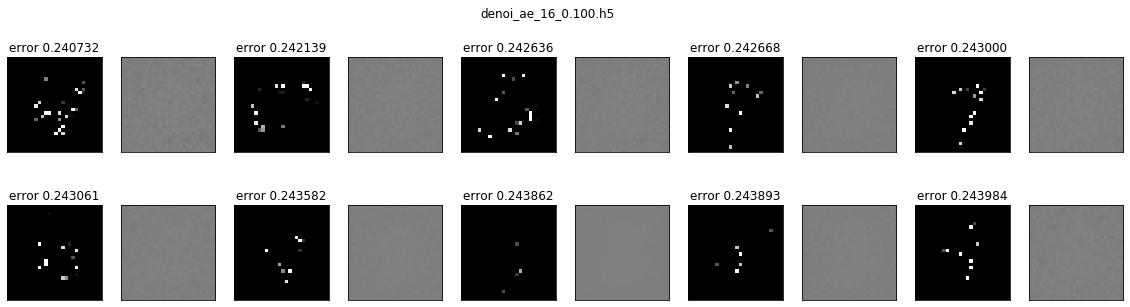

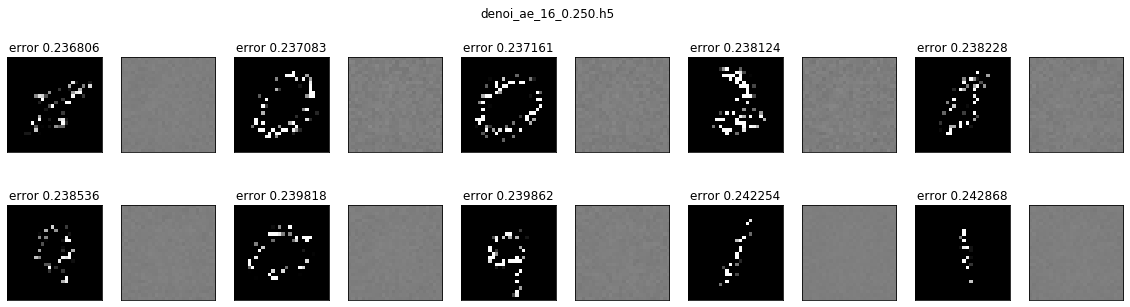

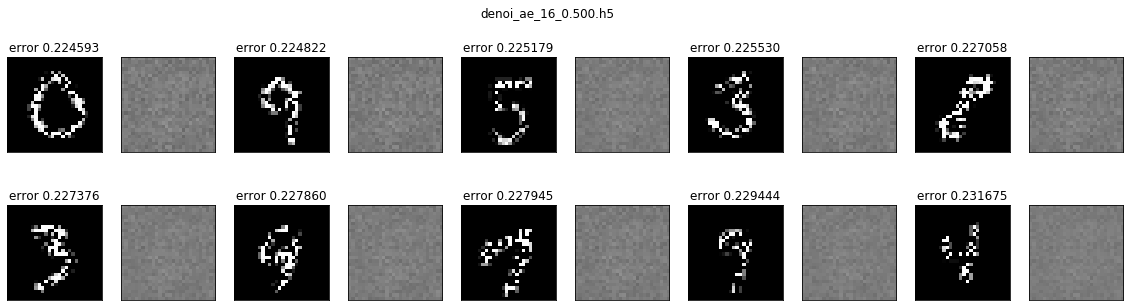

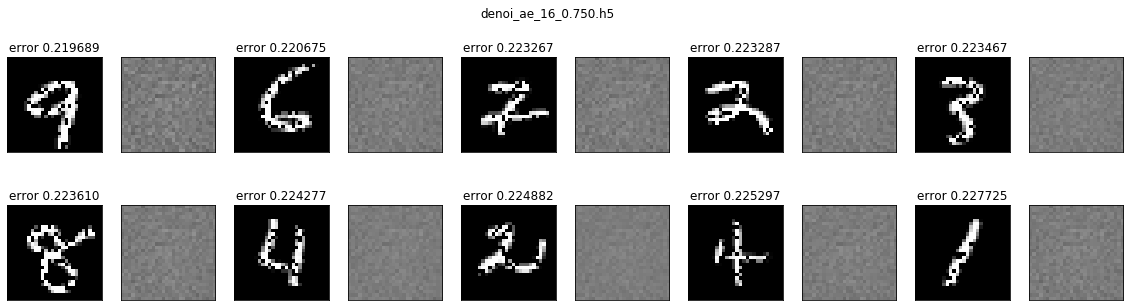

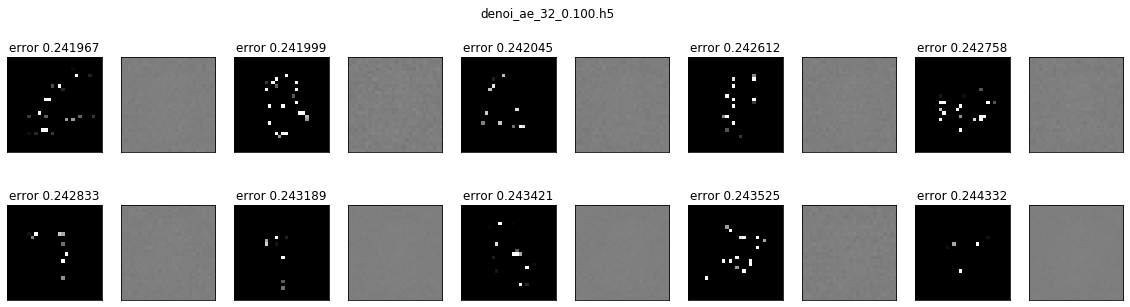

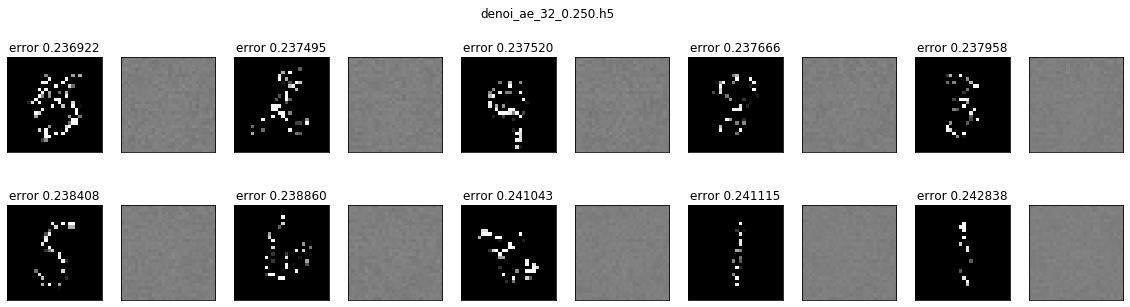

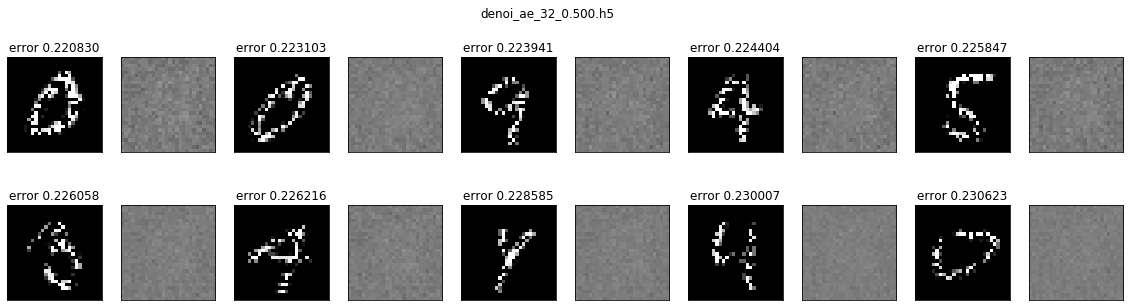

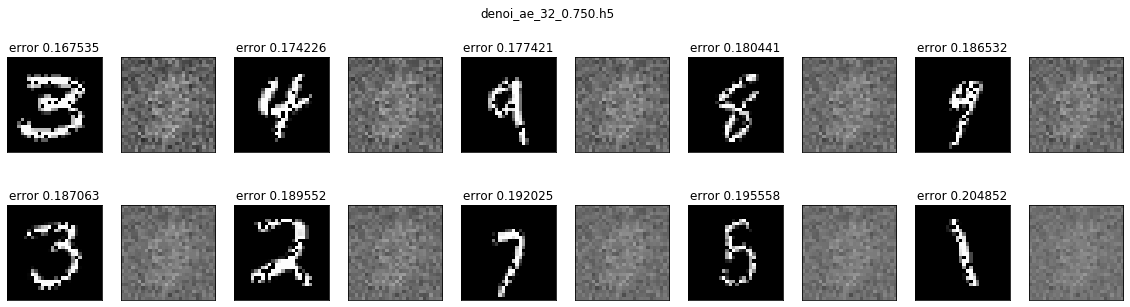

Errors:
	denoi_ae_16_0.100.h5 0.243
	denoi_ae_16_0.250.h5 0.239
	denoi_ae_16_0.500.h5 0.227
	denoi_ae_16_0.750.h5 0.222
	denoi_ae_32_0.100.h5 0.243
	denoi_ae_32_0.250.h5 0.239
	denoi_ae_32_0.500.h5 0.226
	denoi_ae_32_0.750.h5 0.185


In [46]:
total_errors = {}

for dim in DIMS3:
    for p in sorted(list(PVALS)):
        name = "denoi_ae_%d_%.3f.h5"%(dim,p)
        model_ae = keras.models.load_model(name)
        
        noisy_x_test_pred = model_ae.predict(noisy_x_test[p])
        total_error = np.mean((noisy_x_test_pred-noisy_x_test[p])**2)
        total_errors[name] = total_error
        
        idxs = np.arange(noisy_x_test[p].shape[0])
        np.random.shuffle(idxs)
        
        N = 10
        idxs = idxs[:N]
        reals = noisy_x_test[p][idxs]
        preds = model_ae.predict(reals)
        
        errors = np.mean((reals-preds)**2,axis=1)
        # Sort in increasing error
        trf = np.argsort(errors)
        reals = reals[trf]
        preds = preds[trf]
        errors = errors[trf]
        #
        plt.figure(figsize=(2*N,5))
        plt.suptitle(name)
        for i in range(N):
            ax = plt.subplot(2,N,2*i+1)
            ax.set_title("error %f"%errors[i])
            ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
            plt.imshow(reals[i].reshape(28,28),cmap='gray',vmin=0,vmax=1)
            ax = plt.subplot(2,N,2*i+2)
            ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
            plt.imshow(preds[i].reshape(28,28),cmap='gray',vmin=0,vmax=1)
        plt.show()
print("Errors:")
for name in sorted(list(total_errors.keys())):
    print("\t%-20s %.3f"%(name,total_errors[name]))

---

c) Utilice la representación reducida, genera por el *denoising AE*, para **medir el desempeño en clasificación** (vı́a kNN como en la sección anterior). Comente.

In [49]:
for dim in DIMS3:
    for p in sorted(list(PVALS)):
        name = "denoi_ae_%d_%.3f.h5"%(dim,p)
        ename = "denoi_e_%d_%.3f.h5"%(dim,p)
        autoenc = keras.models.load_model(name)
        encoder = keras.models.load_model(ename)
        # Reconstruction error
        x_test_pred_f = autoenc.predict(x_test_f,batch_size=REGULAR_BATCH_SIZE)
        recon_error = np.mean(np.mean((x_test_pred_f-x_test_f)**2,axis=1))
        # Clasification error:
        x_tra_enc = encoder.predict(x_tra_f,batch_size=REGULAR_BATCH_SIZE)
        x_test_enc = encoder.predict(x_test_f,batch_size=REGULAR_BATCH_SIZE)
        clf = sklearn.neighbors.KNeighborsClassifier(10)
        clf.fit(x_tra_enc,y_tra)
        score = clf.score(x_test_enc,y_test)
        print("%2ddims %-30s  score:%.3f  recons:%.3f"%(dim,name,score,recon_error))

16dims denoi_ae_16_0.100.h5            score:0.654  recons:0.226
16dims denoi_ae_16_0.250.h5            score:0.725  recons:0.224
16dims denoi_ae_16_0.500.h5            score:0.671  recons:0.212
16dims denoi_ae_16_0.750.h5            score:0.666  recons:0.216
32dims denoi_ae_32_0.100.h5            score:0.791  recons:0.225
32dims denoi_ae_32_0.250.h5            score:0.836  recons:0.224
32dims denoi_ae_32_0.500.h5            score:0.857  recons:0.211
32dims denoi_ae_32_0.750.h5            score:0.858  recons:0.172


---

d) Diseñe otra manera de generar imágenes corruptas del dataset MNIST, por ejemplo algún tipo de ruido, sea creativo. **Mida el error de reconstrucción y evalúe cualitativamente** (visualización de la imagen corrupta y reconstruida) el resultado para un subconjunto representativo de imágenes.

In [121]:
@numba.jit
def creepy_noise(data,t=30):
    data = np.copy(data).reshape((data.shape[0],28,28))
    for i in range(data.shape[0]):
        for _ in range(t):
            d = random.randint(0,3)
            pos = random.randint(0,27)
            if d==0:
                data[i,pos,:-1] = np.copy(data[i,pos,1:])
            elif d==1:
                data[i,pos,1:] = np.copy(data[i,pos,:-1])
            elif d==2:
                data[i,:-1,pos] = np.copy(data[i,1:,pos])
            elif d==3:
                data[i,1:,pos] = np.copy(data[i,:-1,pos])
    return data.reshape((data.shape[0],28*28))

In [122]:
creepy_x_tra = creepy_noise(x_tra_f)
creepy_x_val = creepy_noise(x_val_f)
creepy_x_test = creepy_noise(x_test_f)

In [123]:
DIM = 32

In [124]:
# ---@> Train model:
model_ae,model_e,model_d = autoencoder(dim,"relu")
model_ae.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
model_ae.fit(creepy_x_tra,x_tra_f,
            epochs=REGULAR_EPOCHS,batch_size=REGULAR_BATCH_SIZE,
            validation_data=(x_val_f,x_val_f))
model_e.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
model_d.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='mse')
#
ename = "creepy_e_%d.h5"%(dim)
dname = "creepy_d_%d.h5"%(dim)
name = "creepy_ae_%d.h5"%(dim)
model_e.save(ename)
model_d.save(dname)
model_ae.save(name)

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 5s 95us/step - loss: 0.2165 - val_loss: 0.1877
Epoch 2/2
55000/55000 [==============================] - 2s 42us/step - loss: 0.1362 - val_loss: 0.0955


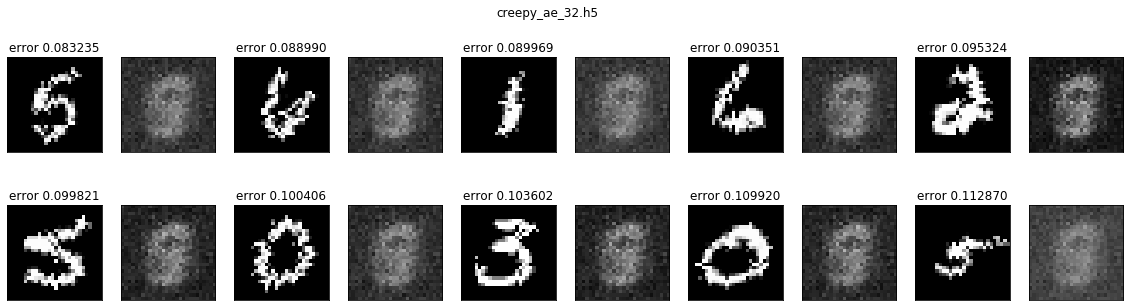

Error:
	creepy_ae_32.h5      0.097


In [125]:
# Load model from the last cell
name = "creepy_ae_%d.h5"%(DIM)

creepy_x_test_pred = model_ae.predict(creepy_x_test)
total_error = np.mean((creepy_x_test_pred-creepy_x_test)**2)

idxs = np.arange(creepy_x_test.shape[0])
np.random.shuffle(idxs)

N = 10
idxs = idxs[:N]
reals = creepy_x_test[idxs]
preds = model_ae.predict(reals)

errors = np.mean((reals-preds)**2,axis=1)
# Sort in increasing error
trf = np.argsort(errors)
reals = reals[trf]
preds = preds[trf]
errors = errors[trf]
#
plt.figure(figsize=(2*N,5))
plt.suptitle(name)
for i in range(N):
    ax = plt.subplot(2,N,2*i+1)
    ax.set_title("error %f"%errors[i])
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    plt.imshow(reals[i].reshape(28,28),cmap='gray',vmin=0,vmax=1)
    ax = plt.subplot(2,N,2*i+2)
    ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    plt.imshow(preds[i].reshape(28,28),cmap='gray',vmin=0,vmax=1)
plt.show()

print("Error:")
print("\t%-20s %.3f"%(name,total_error))

---

### 2.3 *Similarity reconstruct*

En esta sección se explorará una forma diferente de implementar un *autoencoder* que es utilizar la arquitectura del *autoencoder* pero no para reconstruir el mismo dato, sino que para reconstruir un dato similar. En este caso la similaridad estará dada por las clases de los datos.

---

a) Genere pares de objetos $(objeto,similar)$ con 10 datos similares al dato "objeto", para ésto utilice la función que se provee a continuación sobre los primeros (1000 a 2000) datos de entrenamiento. **Visualice los nuevos datos generados y la relación que se produce entre los pares de objetos**.
```python
def similarity_data(X,Y,sim=10):
    index_classes = [ np.where(Y==number)[0] for number in range(10)]
    new_X = np.zeros((1,X.shape[1]))
    simi_X = np.zeros((1,X.shape[1]))
    for x,y in zip(X,Y):
        similarities = index_classes[y]
        sample_sim = np.random.choice(similarities,sim)
        new_X = np.concatenate((new_X, np.tile(x,(sim,1))),axis=0)
        simi_X = np.concatenate((simi_X, X[sample_sim]),axis=0)
    return new_X[1:],simi_X[1:]
data, data_sim = similarity_data(x_train[:2000],y_train[:2000])
...#visualize data
```

---

b) Escoga algunas de las arquitecturas ya experimentadas hasta este punto de la actividad y entrénela para enfrentarla a éste problema **¿La función de pérdida se mantiene?**
```python
autoencoder.fit(data,data_sim,epochs=50,batch_size=32,validation_split=0.2)
```

---

c) **Visualice lo que genera el *autoencoder* dado una imagen de entrada**. Además **visualice, con la herramienta TSNE, los *embedding*/representación reducida** que se producen en el *encoder*.
```python
autoencoder.predict(data)
embeddings = encoder.predict(data) #project this with TSNE
```

---

### 2.4 Pre-*training*

En esta sección utilizaremos un AE para pre-entrenar redes profundas. Como hemos discutido en clases, el efecto esperado es regularizar el modelo, posicionando el modelo de partida en una buena zona del espacio de parámetros.

---

a) Construya y entrene una red FF para clasificar las imágenes de MNIST. Utilice SGD básico con tasa de aprendizaje fija $\eta = 0.01$, momentum $m=0.9$ y no más de 50 *epochs*. Para empezar, utilice una arquitectura $768 \times 1000 \times 1000 \times 10$ y **funciones de activación sigmoidales**. **Determine error de clasificación alcanzado por el modelo en el conjunto de test.**
```python
from keras.utils import to_categorical
Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10)
from keras.models import Sequential
model = Sequential()
model.add(Dense(1000, activation='sigmoid', input_shape=(784,)))
model.add(Dense(1000, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))
model.summary()
optimizer_ = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=optimizer_,loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train,nb_epoch=50, batch_size=25,shuffle=True, validation_data=(x_val, Y_val))
model.save('ReluNet-768x1000x1000x10-NFT-50epochs.h5')
```

---

b) Construya y entrene una red neuronal profunda para clasificar las imágenes de MNIST utilizando la arquitectura propuesta en (a) y pre-entrenando los pesos de cada capa mediante un autoencoder básico. Proceda en modo clásico, es decir, entrenando en modo no supervisado una capa a la vez y tomando como input de cada nivel la representación (entrenada) obtenida en el nivel anterior. Después del entrenamiento efectúe un entrenamiento supervisado convencional (*fine-tunning*). **Compare los resultados de clasificación sobre el conjunto de pruebas con aquellos obtenidos en (a), sin pre-entrenamiento. Evalúe también los resultados antes del *fine-tunning*.** Comente.
```python
from keras.datasets import mnist
... ## Load and preprocess MNIST as usual
...###AUTOENCODER 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer1,activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(inputs=input_img1, outputs=decoded1)
encoder1 = Model(inputs=input_img1, outputs=encoded1)
autoencoder1.compile(optimizer=optimizer_, loss=loss_)
autoencoder1.fit(x_train, x_train, nb_epoch=epochs_, batch_size=batch_size_,shuffle=True, validation_data=(x_val, x_val))
encoded_input1 = Input(shape=(n_hidden_layer1,))
autoencoder1.save('autoencoder_layer1.h5')
encoder1.save('encoder_layer1.h5')
...###AUTOENCODER 2
x_train_encoded1 = encoder1.predict(x_train) #FORWARD PASS DATA THROUGH FIRST ENCODER
x_val_encoded1 = encoder1.predict(x_val)
x_test_encoded1 = encoder1.predict(x_test)
input_img2 = Input(shape=(n_hidden_layer1,))
encoded2 = Dense(n_hidden_layer2, activation=activation_layer2)(input_img2)
decoded2 = Dense(n_hidden_layer2, activation=decoder_activation_2)(encoded2)
autoencoder2 = Model(inputs=input_img2, outputs=decoded2)
encoder2 = Model(inputs=input_img2, outputs=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss=loss_)
autoencoder2.fit(x_train_encoded1,x_train_encoded1,nb_epoch=epochs_,batch_size=batch_size_,shuffle=True, validation_data=(x_val_encoded1, x_val_encoded1))
encoded_input2 = Input(shape=(n_hidden_layer2,))
autoencoder2.save('autoencoder_layer2.h5')
encoder2.save('encoder_layer2.h5')
...#FINE TUNNING
from keras.models import Sequential
model = Sequential()
model.add(Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)))
model.layers[-1].set_weights(autoencoder1.layers[1].get_weights())
model.add(Dense(n_hidden_layer2, activation=activation_layer2))
model.layers[-1].set_weights(autoencoder2.layers[1].get_weights())
model.add(Dense(10, activation='softmax'))
model.summary()
model.compile(optimizer=optimizer_,loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, Y_train,nb_epoch=20, batch_size=25,
shuffle=True, validation_data=(x_val, Y_val))
model.save('Net-768x1000x1000x10-finetunned.h5')
```

---

c) Repita usando funciones de **activación *tanh*. Comente**

---

<a id="refs"></a>
## Referencias
[1] George Kingsley Zipf (1949), *Human behavior and the principle of least effort*, Addison-Wesley Press  
[2] https://www.nvidia.es/object/cuda-parallel-computing-es.html  
[3] http://yann.lecun.com/exdb/mnist/  
[4] Vincent, P., Larochelle, H., Bengio, Y., & Manzagol, P. A. (2008, July). *Extracting and composing robust features with denoising autoencoders*. ACM.